In [1]:
import numpy as np
from PIL import Image

import repath.data.datasets.tissue as tissue
from repath.utils.paths import project_root

from repath.preprocess.tissue_detection import TissueDetectorGreyScale, TissueDetectorOTSU

"""
Global stuff
"""
experiment_name = "tissue"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 123
level_in = 7

In [2]:
# read in slide

datset = tissue.tissue()

test_path = datset.paths.slide[0]
test_path = project_root() / datset.root / test_path
test_path

PosixPath('/home/ubuntu/repath/data/icaird_tissue/images/IC-CX-00001-01.isyntax')

In [3]:
# get thumbnail
with datset.slide_cls(test_path) as slide:
    thumb = slide.get_thumbnail(level_in)

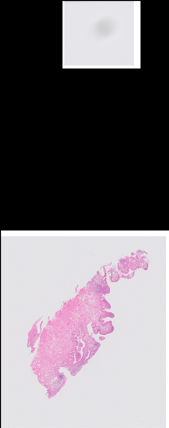

In [4]:
Image.fromarray(thumb)

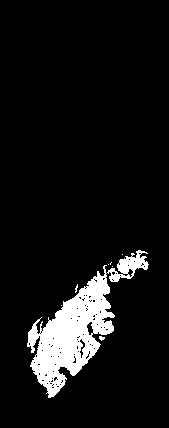

In [5]:
# apply tissue detector

tissue_detector = TissueDetectorOTSU()
tissue_mask = tissue_detector(thumb)
Image.fromarray(np.array(tissue_mask*255, dtype=np.uint8))

In [6]:
im_out = Image.fromarray(np.array(tissue_mask*255, dtype=np.uint8))
im_out.save(project_root() / 'experiments' / 'tissue' / 'test_mask.png')

In [7]:
from skimage.morphology import binary_erosion

# fill holes
# erosion shrinks white holes expands black holes, need to invert the mask
new_mask1 = binary_erosion(tissue_mask)

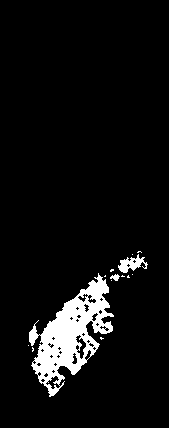

In [8]:
Image.fromarray(np.array(new_mask1*255, dtype=np.uint8))

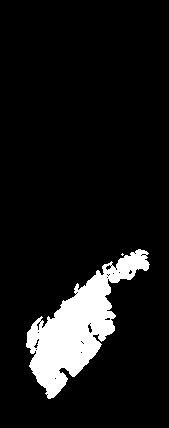

In [9]:
from skimage.morphology import binary_dilation

# fill holes
# erosion shrinks white holes expands black holes, need to invert the mask
new_mask2 = binary_dilation(tissue_mask)
Image.fromarray(np.array(new_mask2*255, dtype=np.uint8))

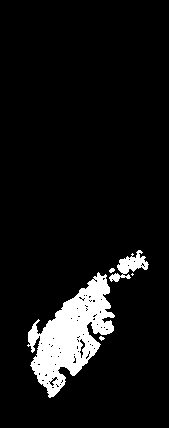

In [10]:
from skimage.morphology import binary_opening

# fill holes
# erosion shrinks white holes expands black holes, need to invert the mask
new_mask3 = binary_opening(tissue_mask)
Image.fromarray(np.array(new_mask3*255, dtype=np.uint8))

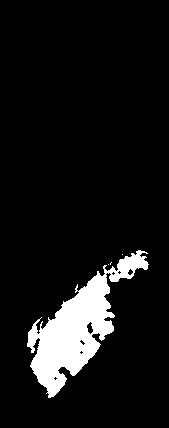

In [11]:
from skimage.morphology import binary_closing

# fill holes
# erosion shrinks white holes expands black holes, need to invert the mask
new_mask4 = binary_closing(tissue_mask)
Image.fromarray(np.array(new_mask4*255, dtype=np.uint8))

In [12]:
# expand around edges

In [13]:
import cv2

contours, hierarchy  = cv2.findContours(np.array(new_mask4, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy  = cv2.findContours(np.array(new_mask4, dtype=np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [14]:
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [-1,  2,  4, -1],
        [ 5, -1, -1,  3],
        [ 6,  4, -1,  3],
        [ 7,  5, -1,  3],
        [ 8,  6, -1,  3],
        [ 9,  7, -1,  3],
        [10,  8, -1,  3],
        [-1,  9, -1,  3]]], dtype=int32)

In [15]:
hierarchy.shape

(1, 11, 4)

In [16]:
# level1
# not sure this copes with more than one nested level.
json_points = []

for ct in range(hierarchy.shape[1]):
    got_parent = hierarchy[0, ct, 3] >= 0
    if not got_parent:
        child_mask = hierarchy[0, ct, :] == ct
        got_kids = np.sum(child_mask) > 0
        if got_kids:
            polygon1 = contours[ct]
            pts = []
            for pt in range(polygon1.shape[0]):
                pnt = polygon1[pt][0].tolist()
                pts.append(pnt)
            json_polygon = [pts]
            kids = contours[np.arrange(len(contours))[child_mask]]
            for kid in kids:
                pts = []
                for pt in range(kid.shape[0]):
                    pnt = kid[pt][0].tolist()
                    pts.append(pnt)
                json_polygon.append(pts)
            json_points.append(json_polygons)
        else:
            pts = []
            for pt in range(contours[ct].shape[0]):
                pnt = contours[ct][pt][0].tolist()
                pts.append(pnt)
            json_points.append(pts)

In [17]:
import json

with open('test_mask_to_qupath.txt', 'w') as outfile:
    json.dump(json_points, outfile)

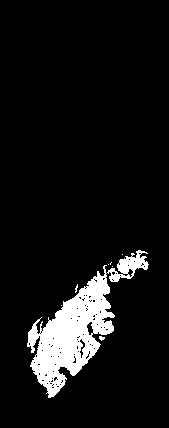

In [18]:
im_out

In [19]:
level_out = 5
level_diff = level_in - level_out
size_diff = 2 ** level_diff
new_size = (im_out.size[0] * size_diff, im_out.size[1] * size_diff)
new_size

(676, 1712)

In [20]:
import cv2
im_resize = im_out.resize(new_size, Image.BOX)
contours, hierarchy  = cv2.findContours(np.array(im_resize, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [21]:
# level1
# not sure this copes with more than one nested level.
json_points = []

for ct in range(hierarchy.shape[1]):
    got_parent = hierarchy[0, ct, 3] >= 0
    if not got_parent:
        child_mask = hierarchy[0, :, 3] == ct
        got_kids = np.sum(child_mask) > 0
        if got_kids:
            polygon1 = contours[ct]
            pts = []
            for pt in range(polygon1.shape[0]):
                pnt = polygon1[pt][0].tolist()
                pts.append(pnt)
            json_polygon = [pts]
            kids = np.array(contours, dtype=object)[np.arange(len(contours))[child_mask]]
            for kid in kids:
                pts = []
                for pt in range(kid.shape[0]):
                    pnt = kid[pt][0].tolist()
                    pts.append(pnt)
                json_polygon.append(pts)
            json_points.append(json_polygon)
        else:
            pts = []
            for pt in range(contours[ct].shape[0]):
                pnt = contours[ct][pt][0].tolist()
                pts.append(pnt)
            json_points.append([pts])
            
json_dict = {'coordinates': json_points}

In [22]:
import json

with open('test_mask_to_qupath3.txt', 'w') as outfile:
    json.dump(json_dict, outfile)

In [23]:
child_mask = hierarchy[0, :, 3] == 7
got_kids = np.sum(child_mask) > 0


TypeError: list indices must be integers or slices, not tuple

In [ ]:
for pt in json_points:
    print('level 1:', len(pt))
    for lv in pt:
        print('level 2:', len(lv))